# TekCollection Test Harness  
### Thomas Ales | June 2020  
-----
Testing for TekCollection functionality.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
import time
sys.path.append('/home/tka/source/visu')
import MapCollection

In [2]:
# Full scan paths
data_dir_prefix = '/home/tka/source/data/customer042/PostFix/'
data_dirs = ['TestScan_000', 'TestScan_020', 'TestScan_040', 'TestScan_060',
             'TestScan_080', 'TestScan_100', 'TestScan_120', 'TestScan_140',
             'TestScan_160']
# Truncated set is 30 rows.
t_data_dir_prefix = '/home/tka/source/data/customer042/PostFix/Cutset/'
t_data_dirs = ['000', '020', '040', '060', '080', '100', '120', '140', '160']


In [3]:
# uncomment these lines to monkey-patch in the truncated dataset.

#data_dir_prefix = t_data_dir_prefix
#data_dirs = t_data_dirs

In [4]:
# build absolute path list
abspathlist = []
for current in data_dirs:
    abspathlist.append(data_dir_prefix + current)
# initalize the collection object
test_mc = MapCollection.TekCollection()

# append maps as if the GUI would
for idx, current in enumerate(abspathlist):
    test_mc.initalize_data(current, idx)

Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files
Found 180 & 180 DC / RF Files


4-t execution: 3.25333s


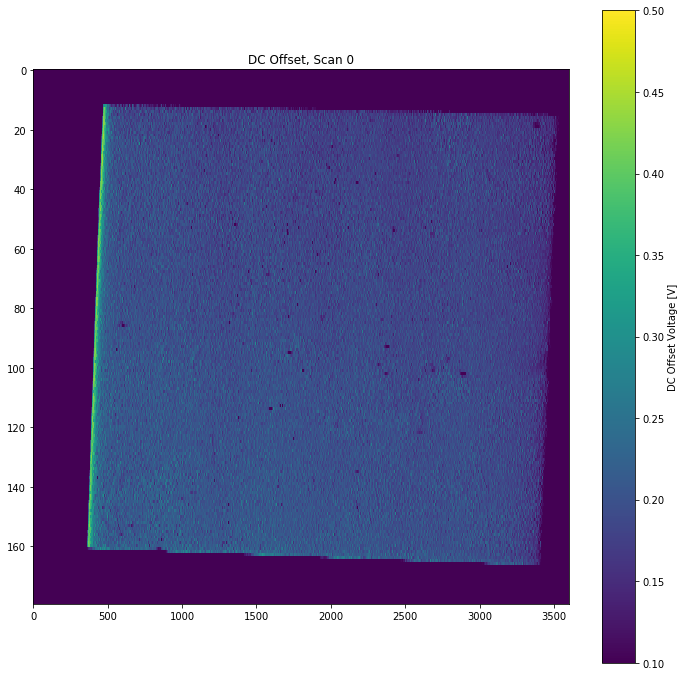

In [5]:
s1 = time.time()
test_mc.process_dc(0)
s2 = time.time()
#test_mc.process_dc(0, 12)
#s3 = time.time()
#test = pickle.load(open('/home/tka/source/data/voltage_test_data.p', 'rb'))
print("4-t execution: {0:.5f}s".format(s2-s1))
#print("24-t execution: {0:.5f}s".format(s3-s2))
plt.figure(figsize=[12, 12])
plt.title("DC Offset, Scan 0")
plt.imshow(test_mc.scans[0].dc_map, aspect=3601/180)
dcbar = plt.colorbar()
plt.clim(0.100, 0.500)
dcbar.set_label("DC Offset Voltage [V]")

In [6]:
#s4 = time.time()
#test_mc.process_fft(0)
#s5 = time.time()
#test_mc.process_fft(0, 12)
#6 = time.time()
#print("1x FFT Execution Time (4-t): {0:.4f} seconds.".format(s5-s4))
#print("1x FFTExecution Time (12-t): {0:.4f} seconds.".format(s6-s5))
#test = pickle.load(open('/home/tka/source/data/fft_test_data.p', 'rb'))
#for idx, current in enumerate(test):
    #mc.map_collections[idx].rf_map = current

In [7]:
s7 = time.time()
for idx in range(0,test_mc.scans.__len__()):
    test_mc.process_dc(idx, 12)
    test_mc.process_fft(idx, 12)
s8 = time.time()
print("9 Angle Total Execution Time (24-t): {0:.4f} seconds.".format(s8-s7))

9 Angle Total Execution Time (24-t): 123.5349 seconds.


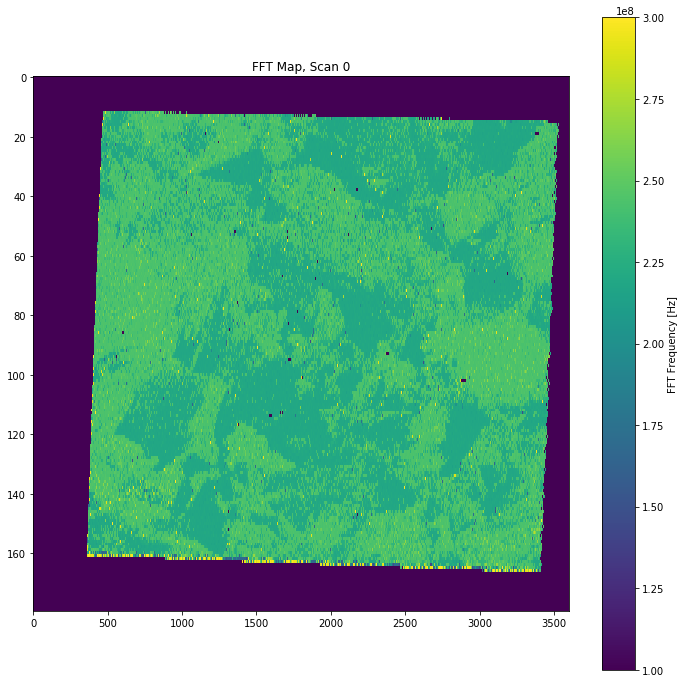

In [8]:
# FFT Test Code
plt.figure(figsize=[12, 12])
plt.imshow(test_mc.scans[0].rf_map, aspect=3601/180)
plt.clim(100E6, 300E6)
rfbar = plt.colorbar()
plt.title("FFT Map, Scan 0")
rfbar.set_label(r"FFT Frequency [Hz]")

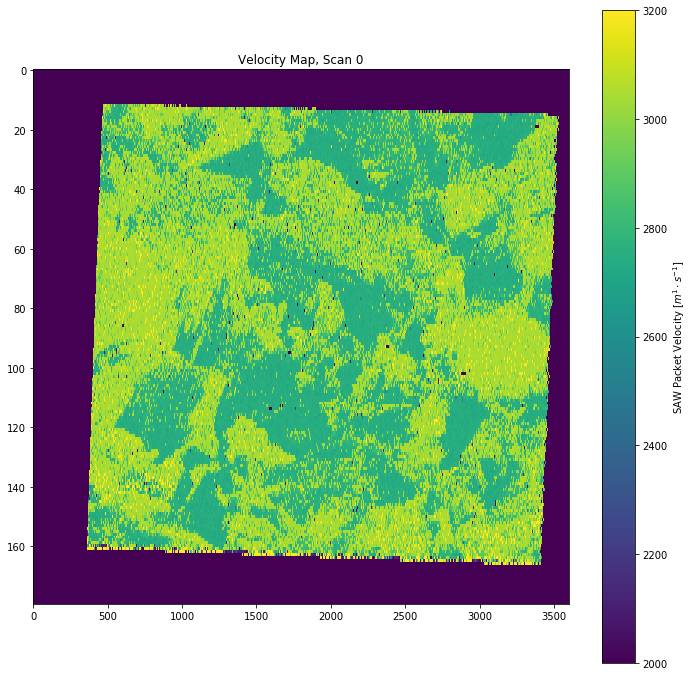

In [9]:
for idx in range(0, 9):
    test_mc.scans[idx].mp_assemble_velocitymap()
plt.figure(figsize=[12,12])
plt.imshow(test_mc.scans[0].velocity_map, aspect=3601/180)
plt.clim(2000, 3200)
vcbar = plt.colorbar()
plt.title("Velocity Map, Scan 0")
vcbar.set_label(r"SAW Packet Velocity [$m^{1} \cdot s^{-1}$]")

In [10]:
# let's try making a numpy array
# 180 rows, 3601 points, 9 scans

map_collection = np.ndarray(shape=(180,3601,9))
for current in range(0,9):
    map_collection[:,:,current] = test_mc.scans[current].velocity_map
    

In [11]:
angles = [0, 20, 40, 60, 80, 100, 120, 140, 160]

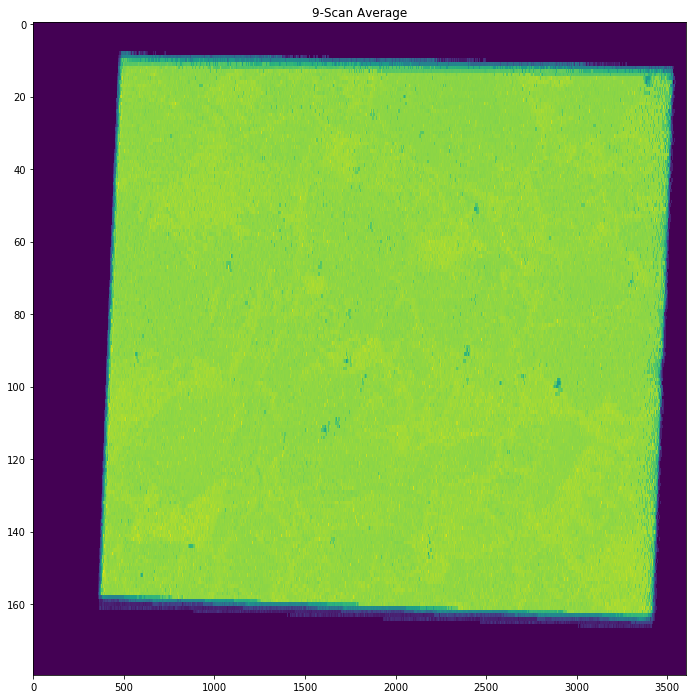

In [12]:
average_map = map_collection.mean(axis=2)
average_map.shape
plt.figure(figsize=[12, 12])
plt.title("9-Scan Average")
plt.imshow(average_map, aspect=3601/180)

In [13]:
interpolated_velocitymap = np.ndarray(shape=(180, 3601, 181))

In [14]:
# Place angles in array z dimension and interpolate
for idx, current in enumerate(angles):
    _temp = test_mc.scans[idx].velocity_map.to_numpy()
    interpolated_velocitymap[:,:,int(current)] = _temp

In [15]:
interpangles = [x for x in range(0, 181)]
for row in range(0, interpolated_velocitymap.shape[0]):
    for column in range(0, interpolated_velocitymap.shape[1]):
        _velocities = []
        for angle in range(0, 9):
            _velocities.append(test_mc.scans[angle].velocity_map.iloc[row,column])
            
        _interp = np.interp(interpangles, angles, _velocities)
        interpolated_velocitymap[row,column,:] = _interp


In [16]:
class WaveModel:

    def __init__(self, _modelfile=''):
        '''
        WaveModel.init(_modelfile='') - Initalizes the WaveModel class and loads in a modelfile.
        '''
        self.modelfile = np.loadtxt('/home/tka/source/wenqi/tiAlphaProcessed_wavespeeds.csv',
                        delimiter=',')
        self.planes = self.modelfile[:, 1:3]
        self.modelfile = self.modelfile[:,3:184] * 1000.0

    def compute_gaussian(self, _x, _mean, _width):
        return (1 / np.sqrt(2*np.pi*(_width**2)))*np.exp((-(_x-_mean)**2)/(2*(_width**2)))

    

In [17]:
test_wm = WaveModel('')
_testplane = interpolated_velocitymap[15, 2000, :]

In [18]:
from functools import partial
experspeeds = _testplane


def compare_against_model(_inputplane):
    _planescore = np.ndarray(shape=(test_wm.modelfile.shape[0], 2))
    # Compare every plane
    for idx, currentplane in enumerate(test_wm.modelfile):
        # For every rotation
        _shiftscore = np.ndarray(shape=(181,1))

        # Roll model input through and compute gaussian filter using the experimental data
        # as the mean which the gaussian is centered about.
        # Use a fugmo list comprehension to do the gaussian.
        for angle in range(0, 181):
            _mod = np.roll(currentplane, angle)
            _planefit = np.array([test_wm.compute_gaussian(
                _inputplane[x], _mod[x], 50) for x in range(0,181)
            ])
            _shiftscore[angle] = _planefit.sum()

        _planescore[idx, 0] = _shiftscore.max()
        _planescore[idx, 1] = _shiftscore.argmax()

    _maxfit = _planescore[:,0].argmax()
    _maxplanex = test_wm.planes[_maxfit, 0]
    _maxplaney = test_wm.planes[_maxfit, 1]
    _maxrot = _planescore[_maxfit, 1]
    return _maxplanex, _maxplaney, _maxrot

def compare_against_model_cpp(_inputplane):
    _planescore = np.ndarray(shape=(test_wm.modelfile.shape[0], 2))
    # Compare every plane
    cppath = '/home/tka/eclipse-workspace/planeoc/Debug/'
    _inputplane = _inputplane.tolist()
    _inputplane = [str('{0:.0f}'.format(x)) for x in _inputplane]
    _inputplane = ','.join(_inputplane)
    for idx, currentplane in enumerate(test_wm.modelfile):
        cplane = test_wm.modelfile[idx].tolist()
        cplane = [str('{0:.0f}'.format(x)) for x in cplane]
        
        excmd = cppath + 'planeoc ' + _inputplane + ' ' + ','.join(cplane)
        #print(excmd)   
        stream = os.popen(excmd)
        result = stream.read()
        _planescore[idx, 0] = float(result.split(',')[-2])
        _planescore[idx, 1] = int(result.split(',')[-1].split('\n')[0]) + 1
        
    _maxfit = _planescore[:,0].argmax()
    _maxplanex = test_wm.planes[_maxfit, 0]
    _maxplaney = test_wm.planes[_maxfit, 1]
    _maxrot = _planescore[_maxfit, 1]

    return _maxplanex, _maxplaney, _maxrot

def compare_against_model_maxc(_inputplane):
    _inputplane = _inputplane.tolist()
    _inputplane = [str('{0:.0f}'.format(x)) for x in _inputplane]
    _inputplane = ','.join(_inputplane)
    cpppath = '/home/tka/eclipse-workspace/planeoc/Debug/'
    excmd = cpppath + 'planeoc '+_inputplane
    #print(excmd)
    stream = os.popen(excmd)
    result = stream.read()
    #print(result)
    _maxfit = int(result.strip('\n').split(',')[0])
    _maxplanex = test_wm.planes[_maxfit, 0]
    _maxplaney = test_wm.planes[_maxfit, 1]
    _maxrot = int(result.strip('\n').split(',')[2])

    return _maxplanex, _maxplaney, _maxrot
def compare_against_model_adaptive(_inputplane):
    
    _rollarr = np.zeros(shape=(181,181), dtype=np.int16)
    _planescore = np.zeros(shape=(test_wm.modelfile.shape[0], 2), dtype=np.float32)
    # compare every plane in the modelfile
    _fscore = np.zeros(shape=(11), dtype=np.float32)
    _cscore = np.zeros(shape=(19), dtype=np.float32)
    _cfit = np.zeros(shape=(181), dtype=np.float32)
    _ffit = np.zeros(shape=(181), dtype=np.float32)
    
    for idx, currentplane in enumerate(test_wm.modelfile):
        currentplane = np.array(currentplane, dtype=np.int16)
        ts3 = time.time()
        #print(_rollarr.shape)
        _rollarr = np.array([np.roll(currentplane, x) for x in range(0,181)], dtype=np.int16)
        #for x in range(0,181):
         #   _rollarr[:,x] = np.roll(currentplane, x)
        # do coarse search first
        #_cscore = []
        for idx2, _cang in enumerate(range(0, 180, 10)):
            # need to multiply modplane by 1000 for units.
            # model is in km/s, need m/s to match data.
            _cscore[idx2] = np.array([test_wm.compute_gaussian(
                _inputplane[x], _rollarr[_cang, x], 50) for x in range(0,181)
            ]).sum()
            
            #_cscore[idx2] = _cfit.sum()
        
        _cmaxfit = _cscore.argmax() * 10
        

        # do a fine search around the winning coarse fit
       # _fscore = []
        for idx3, _fang in enumerate(range(_cmaxfit-5, _cmaxfit+5)):
            _fscore[idx3] = np.array([test_wm.compute_gaussian(
                _inputplane[x], _rollarr[_fang, x], 50) for x in range(0,181)
             ]).sum()
            #_fscore[idx3] = _ffit.sum()
        
        
        _planescore[idx, 0] = _fscore.max()
        _planescore[idx, 1] = _fscore.argmax() + (_cmaxfit - 5)
        ts4 = time.time()
        
    _maxfit = _planescore[:,0].argmax()
    #_maxrot = _planescore[_maxfit, 1]
    print("Single sweep time: {0:.2f}ms".format((ts4-ts3)*1000))
    return _maxfit, _planescore[_maxfit, 1]


```
s1 = time.time()
_x, _y, _rot = compare_against_model(_testplane)
s2 = time.time()
print("Execution time (Python, Full 180): {0:.4f}s.".format(s2-s1))
print("[{0:.2f} {1:.2f} 1], rotation = {2} degrees.".format(
    _x, _y, _rot
))
s1 = time.time()
_planeno, _rot = compare_against_model_adaptive(_testplane)
s2 = time.time()
print("Execution time (Python, Adaptive): {0:.4f}s.".format(s2-s1))
print("[{0:.2f} {1:.2f} 1], rotation = {2} degrees.".format(
    test_wm.planes[_planeno, 0], test_wm.planes[_planeno, 1], _rot
))
s1 = time.time()
_x, _y, _rot = compare_against_model_cpp(_testplane)
s2 = time.time()
print("Execution time (Python/C++, C Per Plane, Full 180): {0:.4f}s.".format(s2-s1))
print("[{0:.2f} {1:.2f} 1], rotation = {2} degrees.".format(
    _x, _y, _rot
))
```

Execution time (MaxC++, Fullsearch440): 0.6170s.
[0.45 0.30 1], rotation = 25 degrees.


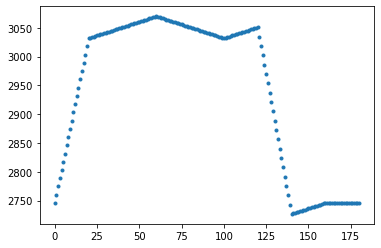

In [19]:
s1 = time.time()
_x, _y, _rot = compare_against_model_maxc(_testplane)
s2 = time.time()
print("Execution time (MaxC++, Fullsearch440): {0:.4f}s.".format(s2-s1))
print("[{0:.2f} {1:.2f} 1], rotation = {2} degrees.".format(
    _x, _y, _rot
))
plt.plot(_testplane, '.')

In [20]:
fitness_scores = np.zeros(181)
ts1 = time.time()
for g in range(0, 181):
    _rollarr = np.roll(test_wm.modelfile[_planeno], g)
    fitness_scores[g] = np.array([test_wm.compute_gaussian(
                _testplane[x], _rollarr[x], 50) for x in range(0,181)
            ]).sum()
ts2 = time.time()
plt.title("Python Non-adaptive Algo Fitness Check\n[0.35, 0.45, 1]\n Core Execution {0:.0f}ms".format((ts2-ts1)*1000))
plt.plot(fitness_scores, '.')

NameError: name '_planeno' is not defined

In [21]:
#s3 = time.time()
#results = []
#with Pool(processes=12) as mpool:
    #results.append(mpool.map(compare_against_model_adaptive, [rowdata[x,:] for x in range(0, 3601)]))
#s4 = time.time()
#print("Execution time: {0:.4f}sec".format(s4-s3))
import pickle
pickle.dump(_testplane, open('/home/tka/source/expplane.p', 'wb'))
pickle.dump(test_wm.modelfile[_planeno], open('/home/tka/source/modelplane.p', 'wb'))

NameError: name '_planeno' is not defined

```
print(results[0][10][2])
resultarray = np.array(results[0][:][:])
plt.figure(figsize=[15,5])
plt.title("[x N 1] plane normal")
plt.plot(resultarray[:,0], '.')
```

```
plt.figure(figsize=[15,5])
plt.title("[N y 1] plane normal")
plt.plot(resultarray[:,1], '.')
```

```
time.time()
maxwinner = test_scores[:,0].max()
maxwinidx = test_scores[:,0].argmax()
plt.figure(figsize=[10, 7])
plt.plot([x for x in range(0, test_wm.modelfile.shape[0])], test_scores[:,0])
plt.plot(maxwinidx, maxwinner, '.', markersize=15)
print("Maximum found for [{0:.2f} {1:.2f} 1] with shift of {2:} degrees. Score = {3:.4f}".format(
    test_wm.planes[maxwinidx, 0], test_wm.planes[maxwinidx, 1], test_scores[maxwinidx, 1],
    maxwinner
))
```

```
plt.figure(figsize=[12, 8])
plt.plot(np.roll(test_wm.modelfile[maxwinidx], 27)*1000.0, '.')
plt.plot(_testplane, '.')
plt.legend(['Model with 27deg', 'Interpolated Experimential'])
```

In [24]:
from multiprocessing import Pool
from skimage.measure import block_reduce
# Downsampling Tests

#downsample = 20
#interpolated_velocitymap_ds = block_reduce(interpolated_velocitymap, 
                                #block_size=(1,downsample,1), func=np.mean)
#s3 = time.time()
#mpool = Pool(processes=12)
#rowdata_ds = interpolated_velocitymap_ds[15,:,:]
#results = []
#results = mpool.map(compare_against_model_adaptive, [rowdata_ds[x,:] for x in range(0, interpolated_velocitymap_ds.shape[1])])
#s4 = time.time()
#print("Execution time: {0:.4f}sec".format(s4-s3))

In [23]:
from skimage.measure import block_reduce
from tqdm.notebook import tqdm
# Downsampling Tests
downsample = 20
interpolated_velocitymap_ds = block_reduce(interpolated_velocitymap, 
                                block_size=(1,downsample,1), func=np.mean)
s3 = time.time()
rowdata_ds = interpolated_velocitymap_ds[15,:,:]
mapresults = []
mpool = Pool(processes=12)
for row in tqdm(range(0,interpolated_velocitymap_ds.shape[0])):
    results = []
    rowdata_ds = interpolated_velocitymap_ds[row,:,:]
    results = mpool.map(compare_against_model_maxc, [rowdata_ds[x,:] for x in range(0, interpolated_velocitymap_ds.shape[1])])
    
    results = np.array(results)
    mapresults.append(results)
npmapresults = np.array(mapresults)
s4 = time.time()
print("Execution time: {0:.4f}sec".format(s4-s3))


Execution time: 2492.0941sec


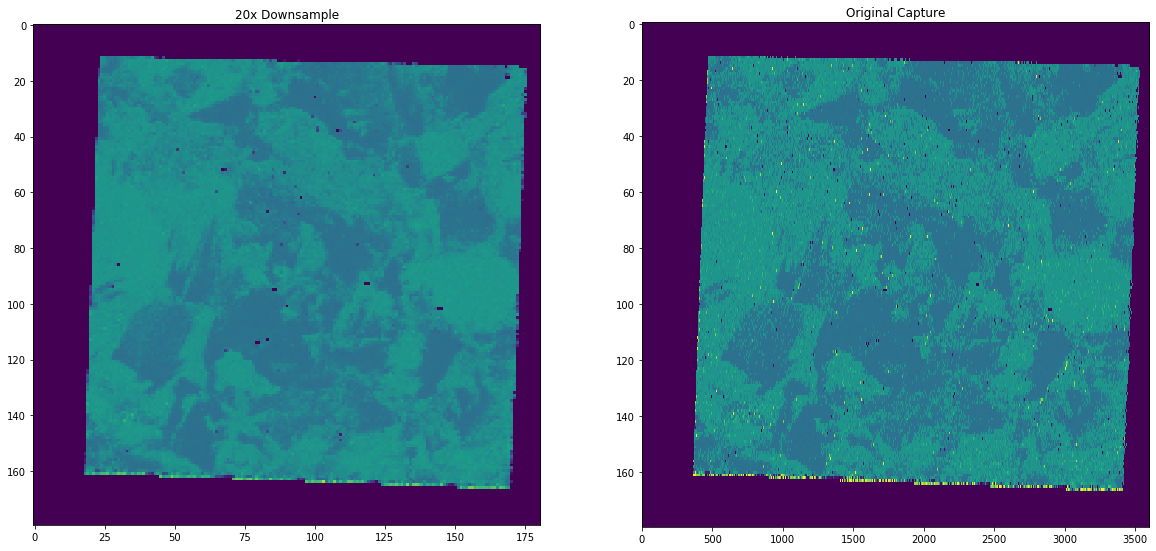

In [25]:
plt.figure(figsize=[20,30])
ax1 = plt.subplot("121")
plt.imshow(interpolated_velocitymap_ds[:,:,0], aspect=(3601/downsample)/181)
plt.clim(2000,4000)
plt.title("{0}x Downsample".format(downsample))
ax2 = plt.subplot("122")
plt.imshow(interpolated_velocitymap[:,:,0], aspect=3601/181)
plt.title("Original Capture")
plt.clim(2000,4000)

In [26]:
mpool.close()

In [38]:
dcmap_ds = block_reduce(test_mc.scans[0].dc_mask, block_size=(1, downsample), func=np.mean)

In [52]:
npmapresults.shape

(180, 181, 3)

In [29]:
r_map = []
for row in range(0, 180):
    r_line = []
    for pixel in range(0, 45):
        r_line.append(mapresults[row][pixel,0])
    r_map.append(r_line)

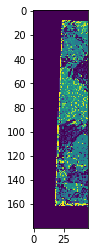

In [30]:
plt.imshow([r_map[x] for x in range(0,180)], aspect=(3601/downsample)/180)

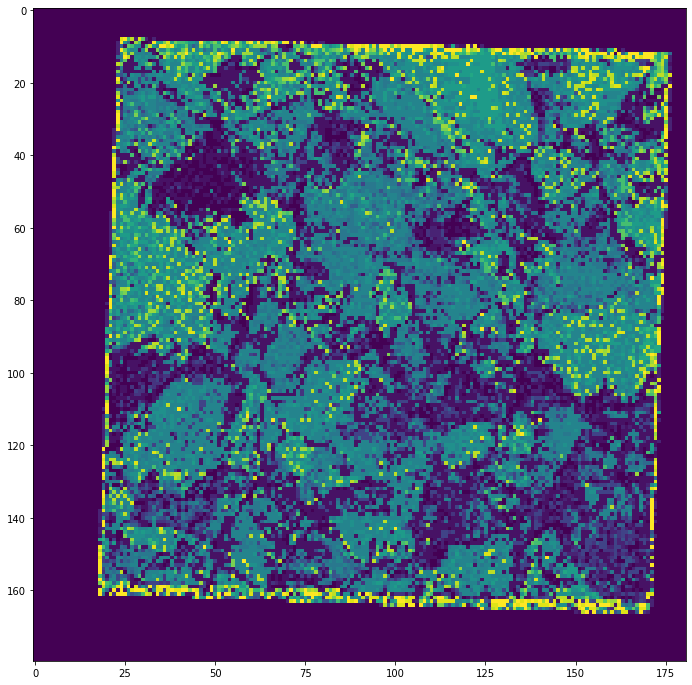

In [31]:
plt.figure(figsize=[12,12])
plt.imshow(npmapresults[:,:,0], aspect=181/180)

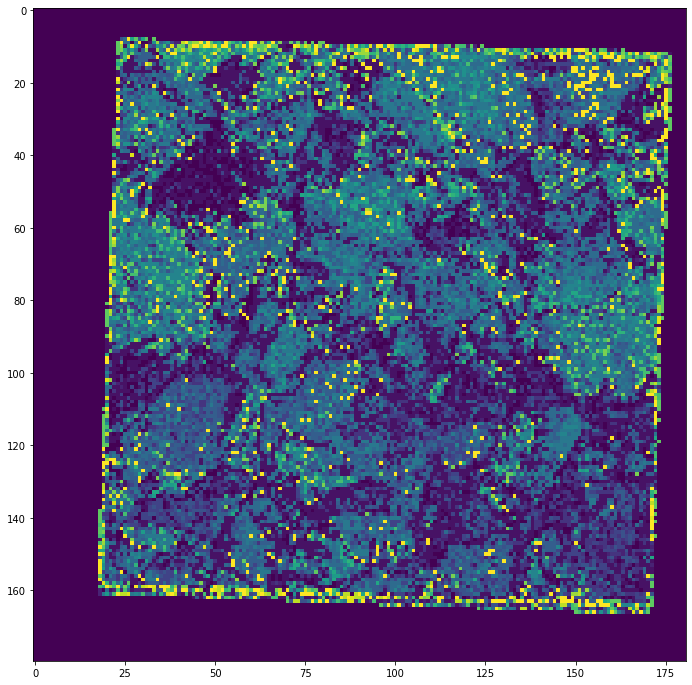

In [32]:
plt.figure(figsize=[12,12])
plt.imshow(npmapresults[:,:,1], aspect=181/180)

In [33]:
import pickle
import os
os.chdir('/home/tka/source/')
#pickle.dump(npmapresults, open('processedmap.pickle', 'wb'))

In [58]:
normalmap = np.zeros(shape=(181,180,3))
rotationmap = np.zeros(shape=(181,180))
for row in range(0, 179):
    for col in range(0, 180):
        normalmap[row,col,0] = npmapresults[row,col,0]
        normalmap[row,col,1] = npmapresults[row,col,1]
        rotationmap[row,col] = npmapresults[row,col,2]
            

In [57]:
npmapresults[40,40,:]

array([ 0.7,  1. , 93. ])

test_wm.planes[int(npmapresults[15,30,0])][z]

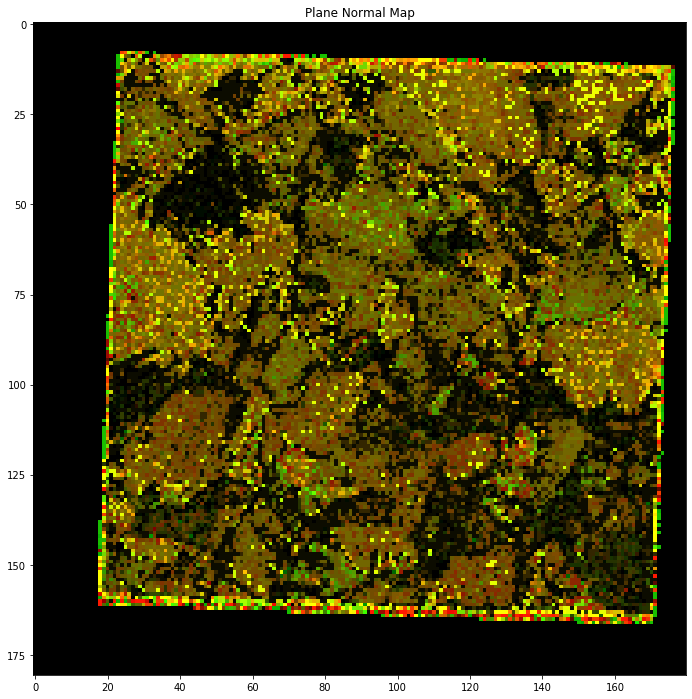

In [60]:
import pickle
oldnormalmap = pickle.load(open('/home/tka/source/processedmap.pickle', 'rb'))
plt.figure(figsize=[12, 12])
plt.title("Plane Normal Map")
plt.imshow(normalmap, aspect=180/181)

In [76]:
pynormalmap = np.zeros(shape=(181,180,3))
pyrotationmap = np.zeros(shape=(181,180))
for row in range(0,180):
    for col in range(0,180):
        pynormalmap[row,col,0] = test_wm.planes[int(oldnormalmap[row,col][0])][0]
        pynormalmap[row,col,1] = test_wm.planes[int(oldnormalmap[row,col][0])][1]
        pyrotationmap[row,col] = oldnormalmap[row,col, 1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


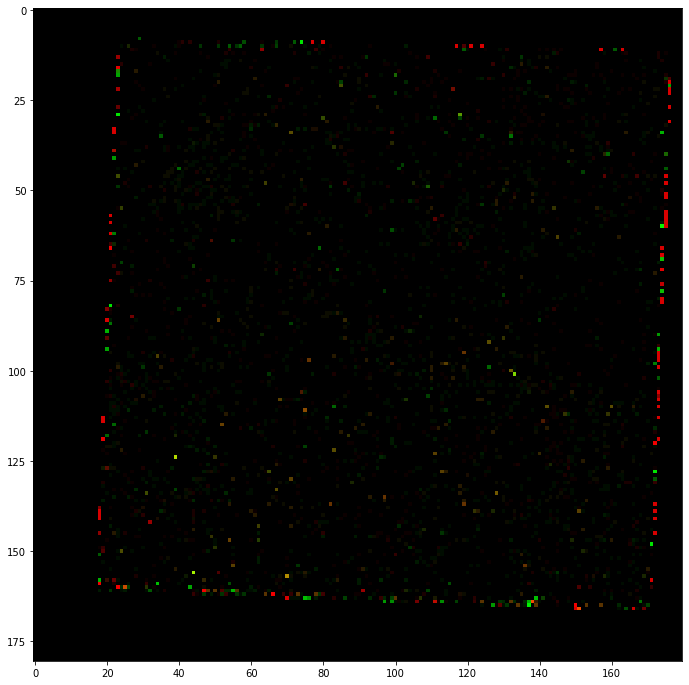

In [79]:
plt.figure(figsize=[12,12])
plt.imshow(pynormalmap - normalmap)

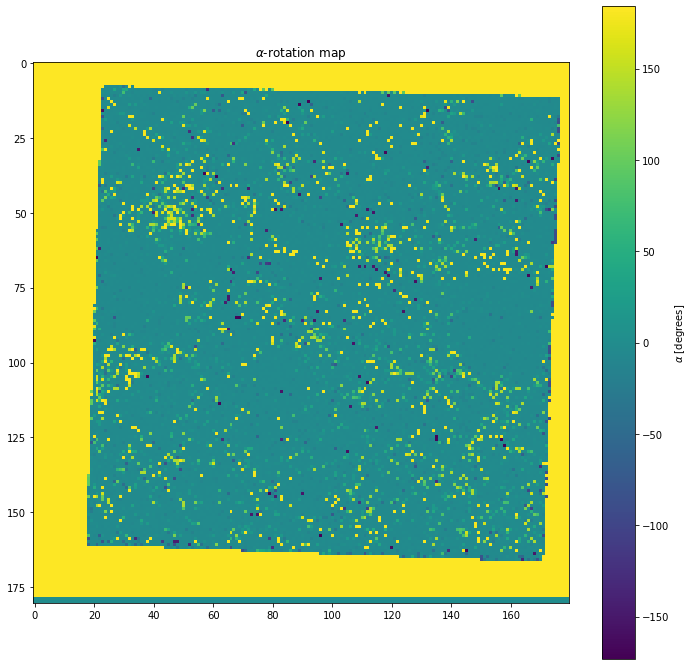

In [80]:
plt.figure(figsize=[12,12])
plt.title(r'$\alpha$-rotation map')
plt.imshow(rotationmap - pyrotationmap, aspect=181/180)
rotbar = plt.colorbar()
rotbar.set_label(r'$\alpha$ [degrees]')
